# Overview

### Predicting the stock price with employment history
### Data collection (YahooFinance API, LinkedIn dataset), profiling and cleaning
### Model construction, LSTMs (hyperparameter tuning)
### Model evaluation and comparison

### Conclusion: In general employment data is not predictive of the stock price, however employment data has more influence in the model performance of the service industry then the product industry.
 


In [37]:
import numpy as np
import pandas as pd
import yahoofinancials as yf
from yahoofinancials import YahooFinancials
%matplotlib inline  
import matplotlib.pyplot as plt
import time
from fuzzywuzzy import fuzz
import pickle

# Data collection



## Employment data

Data source: https://blog.thedataincubator.com/tag/data-sources/

Companies employment histories on LinkedIn is provided by Thinknum, hosted on TDI website. 

In [80]:
df = pd.read_csv('./temp_datalab_records_linkedin_company.csv')
all_comp_names = df['company_name'].unique();
df.head()

,dataset_id,as_of_date,company_name,followers_count,employees_on_platform,link,industry,date_added,date_updated,description,website,entity_id,cusip,isin
0,58329,2015-09-14,Goldman Sachs,552254,38124,https://www.linkedin.com/company/1382,Investment Banking,2015-09-14 00:00:00+00,2015-09-14 00:00:00+00,NaN,NaN,NaN,NaN,NaN
1,58329,2015-09-15,Goldman Sachs,552862,38141,https://www.linkedin.com/company/1382,Investment Banking,2015-09-15 00:00:00+00,2015-09-15 00:00:00+00,NaN,NaN,NaN,NaN,NaN
2,58363,2015-09-16,United Technologies,59157,14982,https://www.linkedin.com/company/2426,Aviation & Aerospace,2015-09-16 00:00:00+00,2015-09-16 00:00:00+00,NaN,NaN,NaN,NaN,NaN
3,58366,2015-09-16,Novo Nordisk,336175,26448,https://www.linkedin.com/company/2227,Pharmaceuticals,2015-09-16 00:00:00+00,2015-09-16 00:00:00+00,NaN,NaN,NaN,NaN,NaN
4,58371,2015-09-16,"Lowe's Companies, Inc.",134255,62574,https://www.linkedin.com/company/4128,Retail,2015-09-16 00:00:00+00,2015-09-16 00:00:00+00,NaN,NaN,NaN,NaN,NaN


Company name and ticker source: http://investexcel.net/all-yahoo-finance-stock-tickers/

In [81]:
ticker = pd.read_csv('./stock_ticker.csv')
ticker= ticker[['Ticker','Name']]
ticker = ticker.loc[~ticker['Ticker'].str.contains('\.|-')]
ticker.head()

,Ticker,Name
0,OEDV,"Osage Exploration and Development, Inc."
1,AAPL,Apple Inc.
2,BAC,Bank of America Corporation
3,AMZN,"Amazon.com, Inc."
4,T,AT&T Inc.


Matching the stock ticker with company name: 
1. Check LinkedIn company name is contained in the ticker company name
2. Find best match by the Levenshtein distance

In [9]:
#find all the most likely matches and pickle the name_ticker dictionary
t0 = time.time()
t0=time.time()
fail = []
comp_tick ={}
for i, name in enumerate(all_comp_names):
  try:
    mask_i = ticker['Name'].str.contains(name)
    mask_i.fillna(False, inplace=True)
    ticker_i = ticker.loc[mask_i]
 
    if ticker_i.shape[0]>=1:
        ticker_i['ratio'] = ticker_i['Name'].apply(lambda row: fuzz.ratio(name,row))
        res = ticker_i.loc[ticker_i['ratio'].idxmax()]
        ratio = ticker_i['ratio'].max()
        if ratio>40:
            print i, '---', name, res.iloc[0], ratio
            comp_tick[name] = res.iloc[0]
        else:
            fail.append(name)
    else:
        fail.append(name)
  except:
    continue
print 'time taken: ', time.time()-t0
pickle.dump(comp_tick, open( "comp_tick_dic.p", "wb" ) )
pickle.dump(fail, open( "comp_fail.p", "wb" ) )


comp_tick = pickle.load( open( "comp_tick_dic.p", "rb" ) )

Bin employment time series by week. Daily employment variation shouldn't be correlated with daily stock price. 

In [94]:
tmin, tmax = df['as_of_date'].min(), df['as_of_date'].max()
t, tbound = tmin, []
while t<tmax:
    tbound.append(t)
    t = pd.to_datetime(t) + pd.DateOffset(days=7)
    t = t.strftime('%Y-%m-%d')    
tmin, tmax

('2015-09-14', '2018-07-17')

In [13]:
#helper function to bin the time series given the boundary. 
def employee_per_wk(df_i, tbd):
    employee_list = []
    for i in xrange(len(tbound)-1):
        mask_bd = (df_i['as_of_date'] >= tbd[i]) & (df_i['as_of_date'] < tbd[i+1])
        df_bin = df_i.loc[mask_bd]
        employee_list.append(df_bin['employees_on_platform'].mean())
    return employee_list

In [83]:
#bining the employment history
t0 = time.time()
nan_count = 0 
'''
comp_emply = {}
for i, name in enumerate(all_comp_names):
    df_i = df.loc[df['company_name']==name]
    week_emply = employee_per_wk(df_i, tbound)
    if np.sum(np.isnan(week_emply))>0:
        nan_count += 1
    comp_emply[name] = week_emply 
pickle.dump(comp_emply, open( "comp_emply_dic.p", "wb" ) )
'''

comp_emply = pickle.load( open( "comp_emply_dic.p", "rb" ) )


Checking the missing values in employment history

In [84]:
count = 0
names_no_nan = []
for name, emply in comp_emply.iteritems():
    emply0 = emply[:]
    if np.sum(np.isnan(emply0)) >0:
        count += 1 
        print name, np.sum(np.isnan(emply0)), count
    else:
        names_no_nan.append(name)
        

Envestnet, Inc 132 1
CUI Global, Inc. 67 2
Wabtec Group 132 3
Gray Television 94 4
Lannett Company 16 5
EchoStar Corporation 52 6
Overland-Tandberg 142 7
iPass 68 8
The Mosaic Company 66 9
Helmerich &amp; Payne 141 10
Mastech Digital 132 11
Dynex Capital 132 12
Amneal Pharmaceuticals 94 13
Prime Offshore L.L.C. 131 14
Concur 94 15
Constellium 65 16
Pivotal, Inc. 107 17
ION Geophysical 65 18
Marrone Bio Innovations 74 19
Q auto 1 20
Cotiviti 124 21
Telefónica 57 22
Athersys 64 23
Canadian Natural Resources Limited (CNRL) 48 24
Apogee Enterprises, Inc. 98 25
Vince 47 26
Canadian Pacific Railway 48 27
Urstadt Biddle Properties Inc. 66 28
Telaria 116 29
Overstock.com 30 30
搜房网 146 31
Chiasma 90 32
Oshkosh Corporation 52 33
South State Bank 82 34
CNB Bank 67 35
Vermilion Energy 88 36
Banco Santander Mexico 65 37
Electro-Sensors, Inc. 67 38
Cooper Tire &amp; Rubber Company 134 39
Third Point Reinsurance Ltd (TPRE) 132 40
Dynasil Corporation of America 67 41
TransUnion 49 42
GenMark Diagnosti

Ennis, Inc. 64 543
Chuy's Restaurants 94 544
Q2ebanking 66 545
Zales The Diamond Store 132 546
Alliant Energy 63 547
Nitric BioTherapeutics, Inc 131 548
AMSC 61 549
Heidrick & Struggles 94 550
Legg Mason 1 551
SharpSpring 82 552
Eldorado Resort Casino - Reno, NV 30 553
DXP Enterprises, Inc. 94 554
Array BioPharma Inc. 64 555
Impinj 113 556
Glacier Bank 61 557
Stayz 132 558
Fortuna Corp 132 559
Intel Business 131 560
1st Constitution Bank 81 561
CVR Partners, LP 66 562
Edgewater Fullscope 67 563
8x8 62 564
THOR Industries, Inc. 51 565
CPS Technologies Corp. 136 566
Acuity Laser Sensors 69 567
Macrocure 132 568
WEX 94 569
RMG Networks 69 570
OpenText 49 571
Patriot Bank is now Green Bank! 132 572
STANLEY Healthcare 146 573
TrueCar, Inc. 52 574
Canon Solutions America 132 575
First Federal Bank of the Midwest 67 576
Blackbaud 52 577
The GEO Group, Inc. 61 578
Inogen 72 579
IHS 71 580
Harte Hanks 65 581
Alliance Coal, LLC 146 582
Systemax 132 583
Lamar Advertising Company 49 584
McDermott 

Bed Bath & Beyond 40 1015
EPAM Systems 52 1016
Knoll 65 1017
BiondVax Pharmaceuticals Ltd. 89 1018
Healthcare Realty 95 1019
BBDO Ukraine 127 1020
Atlantic American 61 1021
Agilysys 63 1022
Worthington Industries 52 1023
BB&T 10 1024
Post Consumer Brands 132 1025
NVR, Inc. 49 1026
Cohu, Inc. 61 1027
Sprouts Farmers Market 52 1028
Otter Tail Corporation 68 1029
PFSweb 26 1030
Ollie's Bargain Outlet, Inc. 51 1031
Helmerich & Payne 52 1032
CBL & Associates Properties, Inc. 138 1033
Hale Hamilton 102 1034
USA Technologies Inc. 99 1035
Voya Financial 49 1036
Achaogen 63 1037
Torrey Pines Bank 52 1038
Tanger Factory Outlet Centers, Inc. 103 1039
AudioCodes 17 1040
Coca-Cola Andina 145 1041
Fitbit 52 1042
KVH Industries, Inc. 68 1043
Darden 43 1044
TCP Capital Corp. 81 1045
C CERAMICS LIMITED 131 1046
FCA Fiat Chrysler Automobiles 9 1047
Celator Pharmaceuticals 132 1048
MerchEngines 131 1049
Sino Global Shipping America 82 1050
Paycom 29 1051
Duluth Trading Company 42 1052
American Railcar In

Kohl's 125 1484
L3 122 1485
Aruba, a Hewlett Packard Enterprise company 131 1486
Coherent Inc. 52 1487
Vishay Intertechnology, Inc. 66 1488
Hibbett Sports 104 1489
Tutor Perini Building Corp 66 1490
Renasant Bank 62 1491
Rocawear 132 1492
Oppenheimer &amp; Co. Inc. 141 1493
Hertz 31 1494
Seacoast Bank 82 1495
Internap Corporation (INAP) 119 1496
RXi Pharmaceuticals Corporation 62 1497
Huttig Building Products 72 1498
ESSA Bank & Trust 67 1499
RSW inc. 131 1500
Delve Networks 131 1501
Vocera 131 1502
Ocean Rig 75 1503
Hawthorn Bank 71 1504
Kearny Bank 71 1505
RLJ Credit 69 1506
MTS - Mer Telemanagement Solutions 118 1507
BTD Manufacturing 94 1508
QuinStreet 54 1509
First Mid-Illinois Bank &amp; Trust 147 1510
Apricus Biosciences, Inc. 64 1511
Five9 67 1512
American Electric Technologies, Inc. 132 1513
TTEC 121 1514
First Mid-Illinois Bank & Trust 70 1515
Applebee's Neighborhood Grill + Bar 78 1516
The Greenbrier Companies 65 1517
Union Bankshares Corp. 80 1518
SEI 49 1519
Mannatech Inco

LaCie 67 2014
Duke Realty Corporation 49 2015
Gogo 45 2016
MSC Industrial Supply Co. 51 2017
DwellStudio 131 2018
Pacific Western Bank 49 2019
NetScaler 132 2020
Reliv International 69 2021
Zoes Kitchen 1 2022
New York &amp; Company 136 2023
GAIN Capital 65 2024
Cboe Global Markets 109 2025
Cavco Industries, Inc. 64 2026
NeuroMetrix, Inc. 95 2027
Control4 67 2028
Stratasys 132 2029
Monroe Capital LLC 73 2030
Cowen Group, Inc. 127 2031
Ohr Pharmaceutical Inc 132 2032
Pep Boys 93 2033
Ameresco 63 2034
Olin 63 2035
Kforce Inc 50 2036
Majesco Entertainment 132 2037
Stock Building Supply is now BMC! 146 2038
Hamilton Bank 71 2039
MACOM 73 2040
The Des Moines Register 132 2041
SQM 65 2042
Adobe Experience Cloud 131 2043
OncoSec 90 2044
SocialCode 132 2045
The Goodyear Tire &amp; Rubber Company 134 2046
Detroit Free Press 132 2047
Magellan Petroleum 132 2048
Atrion Corp 132 2049
Tegra Incorporadora 132 2050
The Scotts Miracle-Gro Company 49 2051
The Howard Hughes Corporation 51 2052
Imbera 13

GSI Technology 67 2443
CRISPR Therapeutics 89 2444
Dover Motorsports Inc. 96 2445
Cenovus Energy 49 2446
Kerr Corporation 90 2447
LightPath Technologies 72 2448
B C E Services Corp 131 2449
TripAdvisor Rentals 132 2450
Boyd Gaming 132 2451
World Fuel Services 52 2452
Mer Telemanagement Solutions (MTS) 102 2453
PDF Solutions 73 2454
Xencor 80 2455
ApartmentHomeLiving.com 57 2456
Arcus Biosciences 141 2457
Scup 132 2458
FastSoft 132 2459
darwin BBDO 127 2460
Republic Bank - Philadelphia & South Jersey 62 2461
West Pharmaceutical Services 30 2462
Schneider 128 2463
Remy International 69 2464
Hydrogenics 72 2465
Charter Communications 48 2466
China Southern Airlines 66 2467
Crescent Point Energy 49 2468
Mobile Mini Solutions 76 2469
Urban Outfitters Europe  132 2470
Prospect Capital Corporation 146 2471
Camping World and Good Sam 122 2472
Putnam Bank 73 2473
LCNB National Bank 71 2474
Esterline 114 2475
LendingClub 92 2476
Biocept - personalized medicine from a liquid biopsy 142 2477
Delux

Red Rock Casino Resort & Spa 139 2891
CommonWealth REIT 131 2892
Xunlei Networking Technologies 80 2893
Ladder Capital Corp 65 2894
Altice USA 59 2895
International Flavors & Fragrances 59 2896
Carmichael Lynch 132 2897
Carnival Cruise Line 48 2898
Nordstrom 3 2899
Western Union 49 2900
HEICO 95 2901
Willis 131 2902
Diversified Restaurant Holdigns, Inc (Nasdaq: SAUC) 143 2903
MutualBank 73 2904
Insteel Industries, Inc 74 2905
Conversant 133 2906
FICO® 9 2907
NorthWestern Energy 52 2908
Cloud Peak Energy 64 2909
Capstone Turbine Corporation 128 2910
Cejka Executive Search℠ 75 2911
Spark Energy 81 2912
Aradigm Corporation 89 2913
FARO Technologies 67 2914
Harvard Apparatus 71 2915
Littelfuse 52 2916
Red Hat Sudamérica y Caribe 132 2917
TIM Brasil 66 2918
Ormat Technologies, Inc. 62 2919
ManTech 133 2920
LogistiCare 73 2921
Heritage Property & Casualty Insurance 143 2922
Cyan, Inc. 131 2923
At Holdings Inc 131 2924
Meridian Bioscience Inc. 74 2925
Avista 61 2926
dec bbdo 127 2927
Veracyte

Caesars Entertainment Corporation 69 3260
Two River Community Bank 62 3261
Oramed Pharmaceuticals Inc. 74 3262
Brown & Brown Insurance 52 3263
GGP Inc. 146 3264
Sears Holdings Corporation 30 3265
Postlets, A Zillow Company 131 3266
Cinedigm 67 3267
ALLTEC GmbH | FOBA Laser Marking + Engraving 90 3268
Northwest Bank 72 3269
UDR - Opening Doors to your Future 145 3270
Hertz Entertainment Services 70 3271
Longhorn Steakhouse 43 3272
Safeguard Scientifics 97 3273
Diodes Incorporated 67 3274
Avid 118 3275
Synacor 81 3276
eTapestry 132 3277
Finisar Corporation (NASDAQ: FNSR) 67 3278
Portola Pharmaceuticals 75 3279
Miller Industries 66 3280
W&amp;T Offshore 147 3281
Office Depot 30 3282
Atento 64 3283
magicJack 96 3284
Fulgent Genetics 90 3285
Roberts 132 3286
Oxiteno 66 3287
WNS Global Services 66 3288
Banco de Chile 142 3289
Healthcare Trust of America, Inc. 51 3290
Coty Inc. 125 3291
Cunard 132 3292
Hibbett Sporting Goods 137 3293
Northfield Bancorp Inc/NJ (NFBK) 132 3294
Dillards dept sto

Atlantic Power Corporation 61 3680
Quidel 62 3681
Smith & Wesson 69 3682
Camden Property Trust 49 3683
Forward Air Corporation 61 3684
Vera Security 132 3685
Oriental 62 3686
National Association of Professional Women (NAPW) 68 3687
Hewlett Packard Enterprise 6 3688
Zebra Technologies 52 3689
Viasat Inc. 115 3690
Workhorse Group Inc. 141 3691
VacantExpress.com® (J.H. Ferguson & Associates) 93 3692
Century Communities, Inc. (NYSE:CCS) 61 3693
iCAD 68 3694
Prothena Corporation plc 73 3695
RAVE Restaurant Group, Inc. 69 3696
Enom 69 3697
Accenture New Zealand 146 3698
JPMorgan Chase & Co. 9 3699
Allen Brothers 132 3700
Carbonite Germany 131 3701
First Financial Bank NA 61 3702
Dyax 132 3703
E. W. Scripps Company 1 3704
TG Therapeutics, Inc. 81 3705
MiX Telematics 56 3706
Orrstown Bank 74 3707
JBT FoodTech 65 3708
Yard House Restaurants 43 3709
Fido Mobile 80 3710
Eaton Vance 51 3711
Oceaneering 52 3712
Security National Life Insurance Company 82 3713
Endologix, Inc. 67 3714
EMCORE Corpora

BBSI 66 4207
XTAR 72 4208
Changyou.com (China) 132 4209
Eaton Vance Management International Ltd. 51 4210
Cardlytics 124 4211
Otonomy, Inc 74 4212
OTT Communications 88 4213
Tanger Outlets 95 4214
OSI Systems 64 4215
IDEXX 11 4216
Prudential Assurance 89 4217
SiPort 132 4218
Kohl's Department Stores 22 4219
China BAK Battery, Inc. 132 4220
Cme Enterprises Ltd 132 4221
Ark Restaurants 64 4222
Cardinal Home Medical 131 4223
TowerJazz 132 4224
Flowers Foods & Subsidiaries 11 4225
Cabot Oil &amp; Gas Corporation 140 4226
II-VI Incorporated 68 4227
Bristow Group 28 4228
THL Credit 74 4229
LandAndFarm 132 4230
White Mountains Capital 132 4231
Wabash National 94 4232
Nalco Champion, An Ecolab Company 132 4233
TriMas Corporation 81 4234
Global Blood Therapeutics 90 4235
Synovus 66 4236
Tonix Pharmaceuticals 90 4237
Hackbright Academy 131 4238
INTL FCStone Inc. 95 4239
Zynerba Pharmaceuticals 16 4240
Lantronix 68 4241
PayPal 26 4242
Intec 132 4243
IntruGuard Devices 131 4244
Cambrex 64 4245
The

Synaptics Incorporated 37 4603
Farmers Capital Bank Corporation 70 4604
Lattice Semiconductor 71 4605
PTC Therapeutics, Inc. 73 4606
Agnico Eagle Mines Limited 49 4607
HRH 131 4608
Cimpress 52 4609
Sunstone Hotel Investors Inc. 132 4610
Vans a Division of VF Outdoor 131 4611
Pacific Biosciences 75 4612
Sterling National Bank 62 4613
PRA Health Sciences 89 4614
Henry Schein 49 4615
Vical 80 4616
Pixartprinting - a Cimpress Company 131 4617
Xenia Hotels & Resorts, Inc. 134 4618
Switch 134 4619
Concho 48 4620
NET1 UEPS Technologies Inc. 124 4621
Revance Therapeutics, Inc. 82 4622
eFax 131 4623
Home Bank 71 4624
Halcon Resources Corporation 65 4625
FICO™ 147 4626
Segmentify 132 4627
Cable ONE 52 4628
Old National Bank 62 4629


In [87]:
print 'full history: ', len(names_no_nan), '/' , len(comp_emply)

 full history:  399 / 5028


In [89]:
name = 'II-VI MARLOW' #'CUI Global, Inc.'
df_i = df.loc[df['company_name']==name] #[['as_of_date', 'company_name','employees_on_platform']] 
week_emply = employee_per_wk(df_i, tbound)
print week_emply
#print np.isnan(week_emply)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 114.0, 112.14285714285714, 112.28571428571429, 114.0, 133.83333333333334, 144.14285714285714, 144.42857142857142, 145.71428571428572, 146.85714285714286, 148.85714285714286, 149.71428571428572, 149.57142857142858, 151.57142857142858, 152.85714285714286, 153.0, 152.71428571428572, 152.0, 153.42857142857142, 155.28571428571428, 155.85714285714286, 156.0, 156.0, 156.71428571428572, 157.0, 157.85714285714286, 159.0, 160.0, 160.0, 159.42857142857142, 161.0, 161.14285714285714, 162.57142857142858, 164.42857142857142, 165.14285714285714, 165.85714285714286, 166.16666666666666, 165.14285714285714, 165.57142857142858, 165.14285714285714, 165.0, 167.0, 167.0, 1

In [91]:
name = 'Yahoo' 
df_i = df.loc[df['company_name']==name]
week_emply = employee_per_wk(df_i, tbound)
print week_emply

[11754.5, 11660.0, 11755.57142857143, 10979.142857142857, 12552.666666666666, 12497.857142857143, 12529.57142857143, 12729.857142857143, 12945.42857142857, 13059.857142857143, 13148.57142857143, 12969.142857142857, 12405.666666666666, 12441.285714285714, 12430.285714285714, 12427.42857142857, 12430.0, 12419.0, 12453.714285714286, 12520.42857142857, 12343.666666666666, 12359.0, 12394.142857142857, 12162.142857142857, 11730.285714285714, 11801.0, 11870.42857142857, 11516.714285714286, 11225.857142857143, 11209.714285714286, 11297.0, 11434.57142857143, 11497.714285714286, 11509.714285714286, 11590.42857142857, 11600.857142857143, 11611.166666666666, 11568.0, 11541.857142857143, 11635.5, 11696.57142857143, 11252.57142857143, 10647.142857142857, 11076.142857142857, 11539.0, 11420.0, 11405.75, 11477.0, 11586.857142857143, 11657.57142857143, 11736.714285714286, 11699.857142857143, 11494.857142857143, 11541.57142857143, 11833.714285714286, 12720.142857142857, 11987.0, nan, nan, nan, nan, nan, 

## Collect stock data
Stock data is collected through YahooFinancial. Then they are binned in the same manner as the employment time series above.

In [ ]:
'''
#for symb_i in symb_list[:1]:
stock_prices_dump = {}
skip_stock =[]
i=0
t1 = time.time()
ttotal = 0
for name, symb_i in comp_tick.iteritems():
  try:
    stocks = YahooFinancials([symb_i])
    t0=time.time()
    stock_prices = stocks.get_historical_price_data(start_date, end_date, 'daily')
    #daily_prices = stock_prices[symb_i]['prices']
    #daily_prices = pd.DataFrame.from_dict(daily_prices)
    #res = price_per_wk(daily_prices, tbound)
    i += 1
    stock_prices_dump[name] = stock_prices
    ttotal += time.time()-t0
    print i, '/', len(comp_tick), name, symb_i, time.time()-t0, ttotal
  except: 
    i += 1
    print i, ' --fail--------------------/', len(comp_tick), name, symb_i, time.time()-t0
    skip_stock.append(name)
    continue
  #if i==50:
  #  break
print 'total time taken: ', time.time()-t1 
pickle.dump(stock_prices_dump, open( "stock_prices_dump.p", "wb" ) ) '''

stock_prices_dump = pickle.load( open( "stock_prices_dump.p", "rb" ) )

In [ ]:
'''
comp_prices = {}
skipped_stock = []
t0 = time.time()
i = 0
for name, symb_i in comp_tick.iteritems():
    #if i==5:
    #    break;
    try:
        print i, name, symb_i, time.time()-t0 #, res
        daily_prices = stock_prices_dump[name][symb_i]['prices']
        daily_prices = pd.DataFrame.from_dict(daily_prices)
        res = price_per_wk(daily_prices, tbound)
        comp_prices[name] = res
        print name, res[:5]
    except:
        skipped_stock.append(name)
        print i, name, symb_i, '----------fail', len(skipped_stock)
        continue
    i += 1
        
pickle.dump(comp_prices, open( "comp_prices.p", "wb" ) ) ''';
comp_prices = pickle.load( open( "comp_prices.p", "rb" ) )

Text(0.5,1,'stock prices')

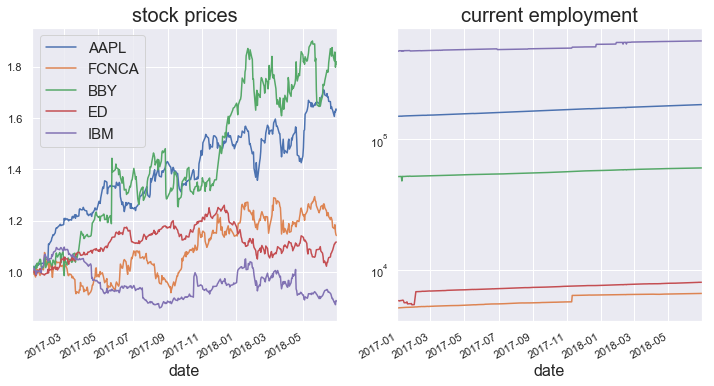

In [223]:
# Below, the left subplot shows the stock price and the right plot shows the number of 
# employees on LinkedIn.
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
for name, symb in zip(comp_names, comp_symbols):
    daily_prices = stock_prices[symb]['prices']
    daily_prices = pd.DataFrame.from_dict(daily_prices)
    mask_s = (daily_prices['formatted_date'] >= startdate) & (daily_prices['formatted_date'] < enddate)
    daily_prices=daily_prices.loc[mask_s]
    daily_prices['adjclose'] = daily_prices['adjclose'].div(daily_prices['adjclose'].iloc[0])
    
    daily_prices['formatted_date'] = pd.to_datetime(daily_prices['formatted_date'])
    daily_prices = daily_prices.set_index('formatted_date')
    daily_prices['adjclose'].plot(label=symb, ax=ax1)

    #employment data
    df_i = df.loc[df['company_name']==name]
    df_i = df_i[['as_of_date','employees_on_platform']]
    df_i['as_of_date'] = pd.to_datetime(df_i['as_of_date'])
    df_i = df_i.set_index('as_of_date')
    df_i['employees_on_platform'].plot(label=name, ax=ax2)
    
    
ax1.legend(fontsize = 15)
#ax2.legend()
ax2.set_yscale('log')
ax2.set_xlabel('date', fontsize=16)
ax2.set_title('current employment', fontsize=20)
ax1.set_xlabel('date', fontsize=16)
ax1.set_title('stock prices', fontsize=20)